In [26]:
import pandas as pd
import numpy as np
import scipy as sp
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Lambda, Dropout, Input, Embedding, Flatten, GaussianNoise
import tensorflow.keras.backend as K
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
import gc
import psutil
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA

<h2>Pair-Wise Siamese Network</h2>

In [2]:
intmatrix = np.load("./data/movie-matrix.npz")['data']
mean = np.sum(intmatrix, axis=1)/(intmatrix!=0).sum(axis=1)
zmask = intmatrix==0
intmatrix = intmatrix-mean.reshape(-1,1)
intmatrix[zmask]=0

In [3]:
genre = pd.read_csv("./data/MovieLens/u.item", sep='\t', encoding='latin-1', header=None)
genre = np.array([np.array(s) for s in genre[0].apply(lambda s: np.array(s.split("|"))).values])
genre = genre[:,6:].astype(np.int)

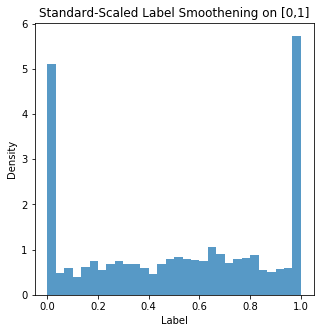

((71951, 3), (17987, 3))

In [4]:
data = pd.DataFrame(intmatrix).stack().reset_index()
data = data[data[0]!=0]
data[0] = (sklearn.preprocessing.StandardScaler().fit_transform(data[[0]])[:,0]+1)/2
data.loc[data[0]>1, 0], data.loc[data[0]<0, 0]= 1, 0
data.columns = ["User", "Item", "Truth"]
plt.figure(figsize=(5,5))
plt.hist(data["Truth"], density=True, alpha=0.75, bins=30)
plt.title("Standard-Scaled Label Smoothening on [0,1]")
plt.xlabel("Label")
plt.ylabel("Density")
plt.show()
np.random.seed(1)
testindex = np.random.choice(data.shape[0], np.int(0.2*data.shape[0]), replace=False)
trainindex = np.array(list(set(np.arange(data.shape[0]))-set(testindex)))
train, test = data.iloc[trainindex], data.iloc[testindex]
train.shape, test.shape

We define the contrastive pair-wise loss used in the network as: <br/>
$L = y \times (1 - \frac{I_1 \cdot I_2}{ ||I_1|| ||I_2||}) + (1-y) \times max(0, C + \frac{I_1 \cdot I_2}{ ||I_1|| ||I_2||}) $ <br/>
where $I_1, I_2$ are the embeddings, $y$ is the smoothened label, and $C$ is a predetermined constant.

In [5]:
def cosine_contrastive_loss(truebin, preddist, C=1):
    return tf.math.reduce_mean(truebin*(1 - preddist) + (1 - truebin)*tf.math.maximum(0.0, C + preddist))

In [6]:
latentdim = 128
userinit = np.random.normal(loc=0, scale=1, size=(intmatrix.shape[0], latentdim))
userinit = userinit/np.sqrt(np.sum(userinit**2, axis=1)).reshape(-1,1)
iteminit = np.random.normal(loc=0, scale=1, size=(intmatrix.shape[1], latentdim))
iteminit = iteminit/np.sqrt(np.sum(iteminit**2, axis=1)).reshape(-1,1)

In [7]:
K.clear_session()
userinput, iteminput = Input((1,)), Input((1,))
#Use fixed 128-length internal vector embeddings
user = Embedding(intmatrix.shape[0], latentdim, weights=[userinit], trainable=True)
item = Embedding(intmatrix.shape[1], latentdim, weights=[iteminit], trainable=True)
useremb = Flatten()(user(userinput))
itememb = Flatten()(item(iteminput))
cosinedist = Lambda(lambda tensors: K.sum(K.l2_normalize(tensors[0], axis=-1)*
                                          K.l2_normalize(tensors[1], axis=-1), axis=-1))
output = cosinedist([useremb, itememb])
model = Model(inputs=[userinput, iteminput], outputs=output)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss=cosine_contrastive_loss)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 128)       120704      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 128)       215296      input_2[0][0]                    
______________________________________________________________________________________________

In [8]:
def lrscheduler(epoch, init=1e-3):
    return init*0.95**np.sqrt(epoch-5) if epoch>5 else init

In [9]:
lr = tf.keras.callbacks.LearningRateScheduler(lrscheduler, verbose=0)
chk = tf.keras.callbacks.ModelCheckpoint("./data/siam.h5", monitor="val_loss", save_weights_only=True, 
                                         save_best_only=True, save_freq="epoch")
hist = model.fit([train["User"], train["Item"]], train["Truth"], validation_data=
                 ([test["User"], test["Item"]], test["Truth"]), batch_size=512, 
                callbacks=[chk, lr], epochs=50, verbose=0)

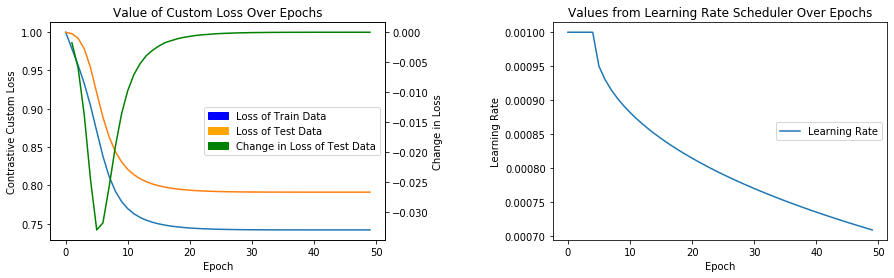

In [10]:
fig = plt.figure(figsize=(15,4))
plt.subplots_adjust(wspace=0.5)
ax = plt.subplot(1,2,1)
pd.Series(hist.history['loss']).plot(ax=ax)
pd.Series(hist.history['val_loss']).plot(ax=ax)
ax1 = ax.twinx()
pd.Series(hist.history['val_loss']).diff().plot(ax=ax1, color="green")
l1 = mpatches.Patch(color="blue", label="Loss of Train Data")
l2 = mpatches.Patch(color="orange", label="Loss of Test Data")
l3 = mpatches.Patch(color="green", label="Change in Loss of Test Data")
plt.legend(handles=[l1,l2,l3], loc="center right")
ax1.set_ylabel("Change in Loss")
ax.set_ylabel("Contrastive Custom Loss")
ax.set_xlabel("Epoch")
plt.title("Value of Custom Loss Over Epochs")
plt.subplot(1,2,2)
pd.Series(np.arange(50)+1).apply(lrscheduler).plot(label="Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Values from Learning Rate Scheduler Over Epochs")
plt.legend(loc="center right")
plt.show()

<h2> Triplet Siamese Training </h2>

We use an alternate training strategy where for each anchor user U, a positive item P and a negative item N are provided, with the objective of minimizing distance between user and positive embedding whilst maximizing the distance from user to negative embedding. We leverage hierarchical pairing, where for a ranked ascending order $P_1, P_2, ..., P_n$ of positive items and ranked ascending order $N_1, N_2,...,N_n$ of negative items, we pair $(P_1,N_1), (P_2,N_2),....,$ $ (P_n,N_n)$. We ensure equal positive and negative entries by splitting at mean, and removing least positive/negative entry $(N_n/P_1)$ if mean involves imbalance.

In [11]:
x = pd.DataFrame(intmatrix).stack().reset_index()
x.drop(x[x[0]==0].index, inplace=True)

In [12]:
neg, pos = x[x[0]<0].copy(), x[x[0]>0].copy()
pos.sort_values(by=["level_0",0], ascending=True, inplace=True)
neg.sort_values(by=["level_0",0], ascending=True, inplace=True)
positiveval, negativeval = pd.DataFrame(), pd.DataFrame()

In [13]:
drop = (pos["level_0"].value_counts().sort_index()-neg["level_0"].value_counts().sort_index())

In [14]:
for user in range(intmatrix.shape[0]):
    drp = drop.get(user, 0)
    positiveval = positiveval.append(pos.loc[pos["level_0"]==user].iloc[max(drp,0):])
    ng = neg.loc[neg["level_0"]==user]
    negativeval = negativeval.append(ng.iloc[:(lambda s: s if s<0 else ng.shape[0])(drp)])

In [15]:
data = pd.concat([positiveval[["level_0","level_1"]].reset_index(drop=True), 
                  negativeval["level_1"].reset_index(drop=True)], axis=1)
data.columns = ["Anchor", "Positive", "Negative"]
np.random.seed(1)
data, data_test = train_test_split(data, test_size=0.2)
data.shape

(28100, 3)

We define triplet loss $L$, for a user embedding $U$, positive item embedding $P$, negative item embedding $N$, and some adjustable hyperparameter $\alpha$ as:
<br/>
$L(U,P,N,\alpha) = max(\frac{U \cdot N}{||U||||N||} - \frac{U \cdot P}{||U||||P||} + \alpha, 0)$ <br/>
Since cosine distances are bounded in $[-1,1]$, we choose $\alpha$ of $2$ to avoid having the gradient descent value for loss function clipped by max.

In [16]:
#ytrue is a dummy value since supervised labels are not provided
#distdiff is the difference in cosine similarity calculated by the lambda layer
def triplet_loss(ytrue, distdiff, alpha=2):
    return tf.reduce_mean(tf.math.maximum(distdiff+alpha, 0.0))

In [17]:
user, positem, negitem = Input((1,)), Input((1,)), Input((1,))
#Use fixed 128-length internal vector embeddings
useremb = Embedding(intmatrix.shape[0], latentdim, weights=[userinit], trainable=True)
itememb = Embedding(intmatrix.shape[1], latentdim, weights=[iteminit], trainable=True)
user2 = Dropout(0.1)(Flatten()(useremb(user)))
positem2 = Dropout(0.1)(Flatten()(itememb(positem)))
negitem2 = Dropout(0.1)(Flatten()(itememb(negitem)))
cosinesim = Lambda(lambda tensors: K.sum(K.l2_normalize(tensors[0], axis=-1)*
                                          K.l2_normalize(tensors[1], axis=-1), axis=-1))
possim = cosinesim([user2, positem2])
negsim = cosinesim([user2, negitem2])
simdiff = Lambda(lambda tensors: tensors[1]-tensors[0])
output = GaussianNoise(0.25)(simdiff([possim, negsim]))
model2 = Model(inputs=[user, positem, negitem], outputs=output)
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss=triplet_loss)
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 128)       120704      input_3[0][0]                    
____________________________________________________________________________________________

In [18]:
lr = tf.keras.callbacks.LearningRateScheduler(lrscheduler, verbose=0)
chk = tf.keras.callbacks.ModelCheckpoint("./data/siam.h5", monitor="val_loss", save_weights_only=True, 
                                         save_best_only=True, save_freq="epoch")
hist = model2.fit([data["Anchor"], data["Positive"], data["Negative"]], np.zeros(data.shape[0]), validation_data=
                 ([data_test["Anchor"], data_test["Positive"], data_test["Negative"]], 
                  np.zeros(data_test.shape[0])), batch_size=512, callbacks=[chk, lr], epochs=50, verbose=0)

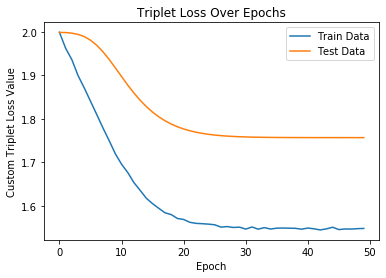

In [19]:
pd.Series(hist.history["loss"]).plot(label="Train Data")
pd.Series(hist.history["val_loss"]).plot(label="Test Data")
plt.xlabel("Epoch")
plt.ylabel("Custom Triplet Loss Value")
plt.legend(loc="best")
plt.title("Triplet Loss Over Epochs")
plt.show()

<h2>Inference Time Graphs </h2>

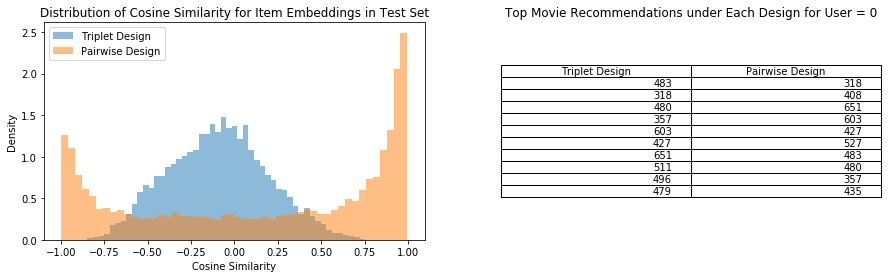

In [20]:
#Inference-Time Triplet Graph
TripletModel = Model(inputs=[user,positem], outputs=possim)
triptest = data_test[["Anchor", "Positive"]].append(
    data_test[["Anchor","Negative"]].rename(columns={"Negative":"Positive"}))
triptest = TripletModel.predict([data_test["Anchor"],data_test["Negative"]])
pairtest = model.predict([test["User"], test["Item"]])
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.hist(triptest, bins=50, density=True, alpha=0.5, label="Triplet Design")
plt.hist(pairtest, bins=50, density=True, alpha=0.5, label="Pairwise Design")
plt.xlabel("Cosine Similarity")
plt.ylabel("Density")
plt.title("Distribution of Cosine Similarity for Item Embeddings in Test Set")
plt.legend(loc="best")
ax = plt.subplot(1,2,2)
userval = 0
items = np.where(intmatrix[userval]==0)[0]
triptest = TripletModel.predict([np.repeat(userval,items.shape[0]),items])
pairtest = model.predict([np.repeat(userval,items.shape[0]),items])
triptest = pd.Series(triptest, index=items).sort_values(ascending=False).iloc[:10].index.values+1
pairtest = pd.Series(pairtest, index=items).sort_values(ascending=False).iloc[:10].index.values+1
ax.axis('tight')
ax.axis('off')
ax.table(cellText=np.concatenate([triptest.reshape(-1,1),pairtest.reshape(-1,1)],axis=1),
         colLabels=["Triplet Design","Pairwise Design"], loc="center")
plt.title("Top Movie Recommendations under Each Design for User = "+str(userval))
plt.show()

In [21]:
#Correlation Between Deviations from Mean and Predicted Cosine Similarity
def corranalysis(userseries, itemseries, model, title):
    plt.figure(figsize=(15,4))
    np.random.seed(0)
    randomusers = np.random.choice(intmatrix.shape[0], 10, replace=False)
    plt.subplot(1,2,1)
    select = userseries.isin(randomusers)
    y = pd.concat([userseries,itemseries],axis=1).apply(lambda s: intmatrix[s.values[0], s.values[1]], axis=1)
    x = model.predict([userseries, itemseries])
    plt.scatter(x[select],y[select])
    plt.xlabel("Predicted Similarity")
    plt.ylabel("Final Ratings Parameter")
    #Null Hypothesis Testing
    #Difference in Means of Ratings
    lowmean, highmean = y[x<0].mean(), y[x>0].mean()
    lowstd, highstd = y[x<0].std(ddof=1), y[x>0].std(ddof=1)
    pval = sp.stats.t.cdf(0, len(y[x!=0])-1, loc=highmean-lowmean, 
                             scale=np.sqrt((lowstd**2)/len(y[x<0]) + (highstd**2)/len(y[x>0])))
    #Maximum Likelihood Estimate for Least Squares Regression Slope
    lowpred_betaMLE = np.sum((x[x<0]-x[x<0].mean())*(y[x<0]-y[x<0].mean()))/np.sum(
        (x[x<0]-x[x<0].mean())**2)
    highpred_betaMLE = np.sum((x[x>0]-x[x>0].mean())*(y[x>0]-y[x>0].mean()))/np.sum(
        (x[x>0]-x[x>0].mean())**2)
    lowpred_alphaMLE = y[x<0].mean() - lowpred_betaMLE * x[x<0].mean()
    lowpred_Se = np.sum((y[x<0] - lowpred_alphaMLE - lowpred_betaMLE*x[x<0])**2)/(np.sum(x<0)-2)
    term = np.abs(highpred_betaMLE-lowpred_betaMLE)/(lowpred_Se/np.sqrt(np.sum(
        (x[x<0]-x[x<0].mean())**2)))
    term = 2-2*sp.stats.t.cdf(term, np.sum(x<0), loc=0, scale=1)
    metrics = np.array(["Mean Rating for Similarity<0", "Mean Rating for Similarity>0", 
               "One-Sided Test P-Value on Two Means","Linear Reg. Beta MLE for Similarity<0",
              "Linear Reg. Beta MLE for Similarity>0","Two-Sided P-Value (H_0=Slope Equality)"])
    values = np.array([lowmean, highmean, pval, lowpred_betaMLE, highpred_betaMLE, term])
    ax = plt.subplot(1,2,2)
    ax.axis('tight')
    ax.axis('off')
    ax.table(cellText=np.concatenate([metrics.reshape(-1,1), values.reshape(-1,1)],axis=1), 
            colLabels=["Metrics", "Value"], loc="center")
    plt.suptitle(title)
    plt.show()

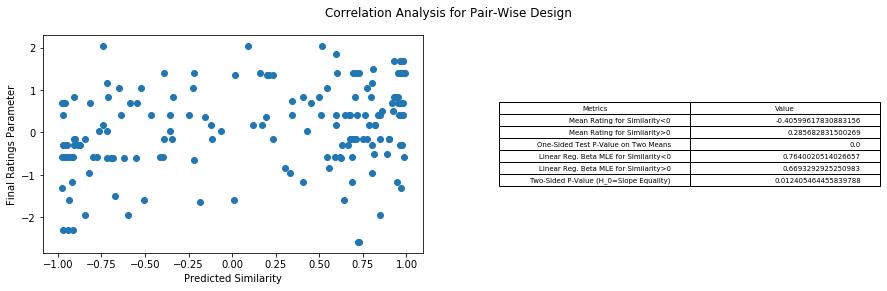

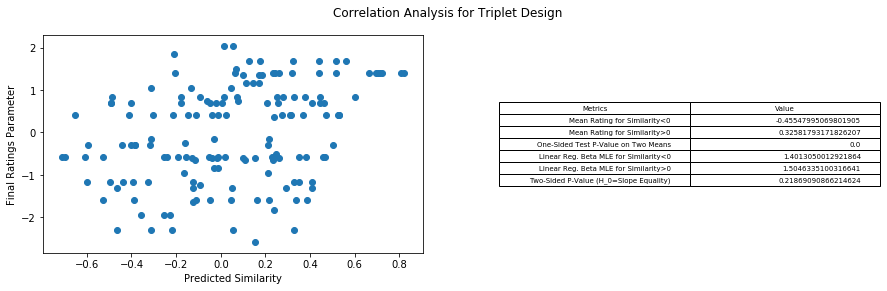

In [22]:
corranalysis(test["User"], test["Item"], model, "Correlation Analysis for Pair-Wise Design")
triptest = data_test[["Anchor", "Positive"]].append(
    data_test[["Anchor","Negative"]].rename(columns={"Negative":"Positive"}))
corranalysis(triptest["Anchor"], triptest["Positive"], TripletModel, "Correlation Analysis for Triplet Design")

In [73]:
def embeddings_plotter(items, relratings, model, user):
    trf = PCA()
    trf.fit(np.concatenate([weight.numpy() for weight in model.weights]))
    itemb = trf.transform(model.weights[1].numpy()[np.array(items)])[:,:2]
    usemb = trf.transform(model.weights[0].numpy()[np.array([user])])[:,:2]
    plt.scatter(itemb[np.array(relratings)>0][:,0], itemb[np.array(relratings)>0][:,1], color="green",
               label="Positive Preference Items")
    plt.scatter(itemb[np.array(relratings)<0][:,0], itemb[np.array(relratings)<0][:,1], color="red",
               label="Negative Preference Items")
    plt.scatter(usemb[:,0], usemb[:,1], color="black",
               label="User Embedding")
    plt.legend(loc="best")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")

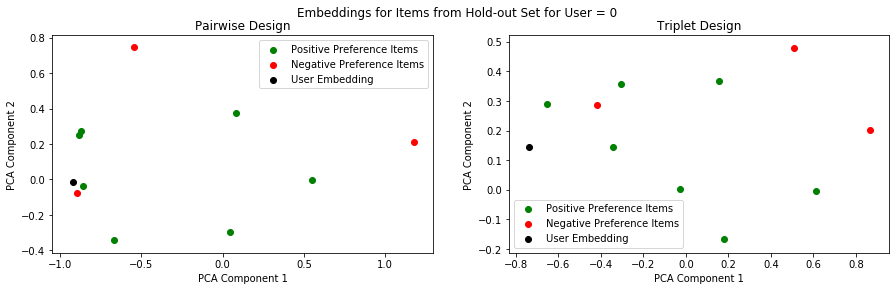

In [88]:
plt.figure(figsize=(15,4))
userval = 0
intmatrix = np.load("./data/movie-matrix.npz")['data']
mean = np.sum(intmatrix, axis=1)/(intmatrix!=0).sum(axis=1)
test_x = pd.read_csv("./data/MovieLens/ua.test", sep='\t', encoding='latin-1', header=None)
test_x = test_x.loc[test_x[0]==(userval+1)]
plt.subplot(1,2,1)
plt.title("Pairwise Design")
embeddings_plotter((test_x[1]-1).values, (test_x[2]-mean[userval]).values, model, userval)
plt.subplot(1,2,2)
plt.title("Triplet Design")
embeddings_plotter((test_x[1]-1).values, (test_x[2]-mean[userval]).values, TripletModel, userval)
plt.suptitle("Embeddings for Items from Hold-out Set for User = "+str(userval))
plt.show()